# Import Libraries

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
import findspark
findspark.init()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import warnings
import urllib.request
import pyspark.sql.functions as sf
from pyspark.sql.types import StringType, IntegerType, DoubleType, StructType, StructField
from pyspark import sql

warnings.filterwarnings('ignore')

In [ ]:
spark = sql.SparkSession.builder \
    .master("local") \
    .appName("Youtube EDA") \
    .getOrCreate()

# Import Preprocessed Data into Spark DataFrames

In [ ]:
General_url = "https://billypoon.blob.core.windows.net/project/data/processed"

CA_url = General_url+"/CA.csv"
IN_url = General_url+"/IN.csv"
GB_url = General_url+"/GB.csv"
US_url = General_url+"/US.csv"
DE_url = General_url+"/DE.csv"
FR_url = General_url+"/FR.csv"

CA_file = "CA.csv"
IN_file = "IN.csv"
GB_file = "GB.csv"
US_file = "US.csv"
DE_file = "DE.csv"
FR_file = "FR.csv"

urllib.request.urlretrieve(CA_url, CA_file)
urllib.request.urlretrieve(IN_url, IN_file)
urllib.request.urlretrieve(GB_url, GB_file)
urllib.request.urlretrieve(US_url, US_file)
urllib.request.urlretrieve(DE_url, DE_file)
urllib.request.urlretrieve(FR_url, FR_file)

('FR.csv', <http.client.HTTPMessage at 0x7ff2ce85a358>)

In [ ]:
custom_schema = StructType([
    StructField('video_id', StringType(), False),
    StructField('title', StringType(), False),
    StructField('category_id', IntegerType(), False),
    StructField('tags', StringType(), False),
    StructField('views', IntegerType(), False),
    StructField('likes', IntegerType(), False),
    StructField('dislikes', IntegerType(), False),
    StructField('comment_count', IntegerType(), False),
    StructField('description', StringType(), False),
    StructField('category_title', StringType(), False),
    StructField('region', StringType(), False),
    StructField('lang', StringType(), False)
])

df_IN = spark.read.csv(IN_file, header=True, schema=custom_schema, multiLine=True)
df_GB = spark.read.csv(GB_file, header=True, schema=custom_schema, multiLine=True)
df_US = spark.read.csv(US_file, header=True, schema=custom_schema, multiLine=True)
df_CA = spark.read.csv(CA_file, header=True, schema=custom_schema, multiLine=True)
df_DE = spark.read.csv(DE_file, header=True, schema=custom_schema, multiLine=True)
df_FR = spark.read.csv(FR_file, header=True, schema=custom_schema, multiLine=True)
df_ALL = df_IN.union(df_GB).union(df_US).union(df_CA).union(df_DE).union(df_FR)

In [ ]:
df_ALL.groupBy('region').count().orderBy('count').show()

+------+-----+
|region|count|
+------+-----+
|    IN|37246|
|    GB|38826|
|    DE|40584|
|    FR|40610|
|    CA|40807|
|    US|40949|
+------+-----+



In [ ]:
df_IN.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- category_title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- lang: string (nullable = true)



In [ ]:
df_IN.describe().show()

+-------+-----------+--------------------+-----------------+--------------------+------------------+-----------------+------------------+------------------+--------------------+----------------+------+-----+
|summary|   video_id|               title|      category_id|                tags|             views|            likes|          dislikes|     comment_count|         description|  category_title|region| lang|
+-------+-----------+--------------------+-----------------+--------------------+------------------+-----------------+------------------+------------------+--------------------+----------------+------+-----+
|  count|      37246|               37246|            37246|               37246|             37246|            37246|             37246|             37246|               36685|           37246| 37246|37241|
|   mean|       null|                null|21.55557643773828|                null|1063316.6141867584|27153.89878107716|1669.5837673844171| 2684.263920957955|            

# Views, Likes, Dislikes, and Comment count Distribution

In [ ]:
def getViewDataDistribution(df, title):
    df = df.withColumn('log_views', sf.log10(df.views))
    df = df.withColumn('log_likes', sf.log10(df.likes))
    df = df.withColumn('log_dislikes', sf.log10(df.dislikes))
    df = df.withColumn('log_comment_count', sf.log10(df.comment_count))

    fig = plt.figure(figsize = (12,6))
    fig.suptitle(title, fontsize=24)
    ax1 = plt.subplot(221)
    graph1 = sns.distplot(df.select("log_views").rdd.flatMap(lambda x: x).collect())
    ax1.title.set_text('log views')

    ax2 = plt.subplot(222)
    graph2 = sns.distplot(df.select("log_likes").rdd.flatMap(lambda x: x).collect())
    ax2.title.set_text('log likes')

    ax3 = plt.subplot(223)
    graph3 = sns.distplot(df.select("log_dislikes").rdd.flatMap(lambda x: x).collect())
    ax3.title.set_text('log dislikes')

    ax4 = plt.subplot(224)
    graph4 = sns.distplot(df.select("log_comment_count").rdd.flatMap(lambda x: x).collect())
    ax4.title.set_text('log comment count')

    plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
    plt.show()

    del df
    gc.collect()

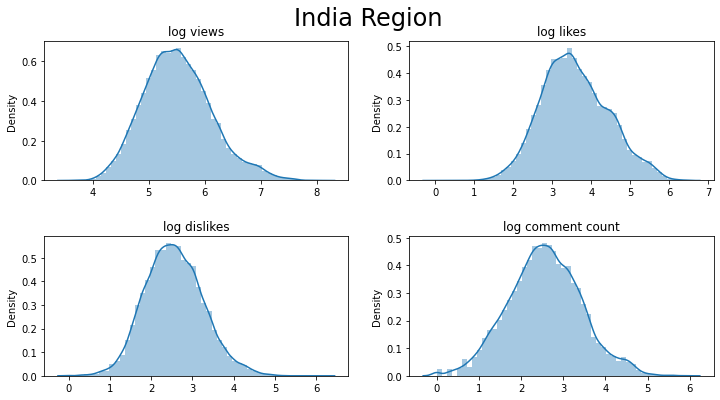

In [ ]:
getViewDataDistribution(df_IN, 'India Region')

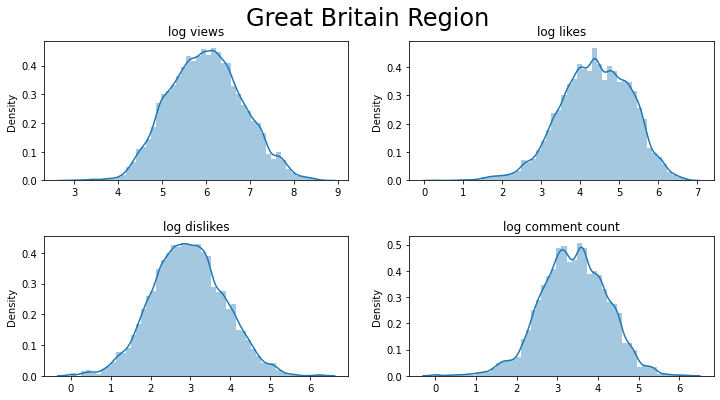

In [ ]:
getViewDataDistribution(df_GB, 'Great Britain Region')

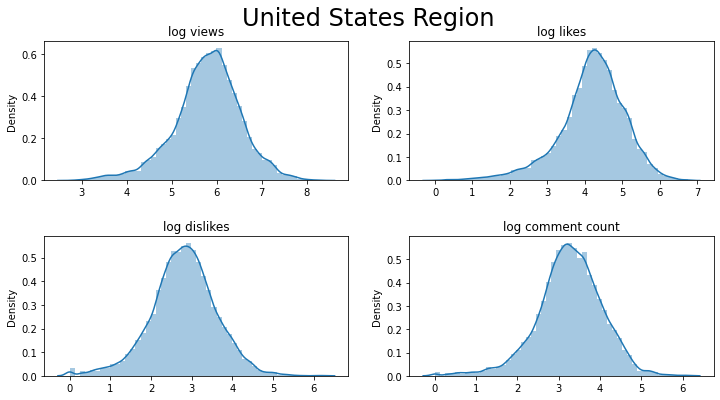

In [ ]:
getViewDataDistribution(df_US, 'United States Region')

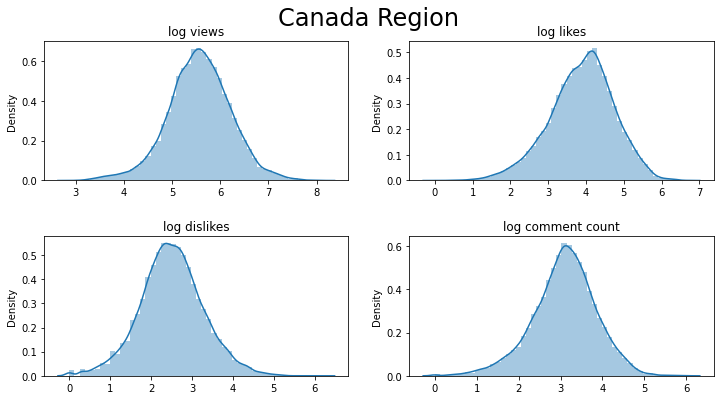

In [ ]:
getViewDataDistribution(df_CA, 'Canada Region')

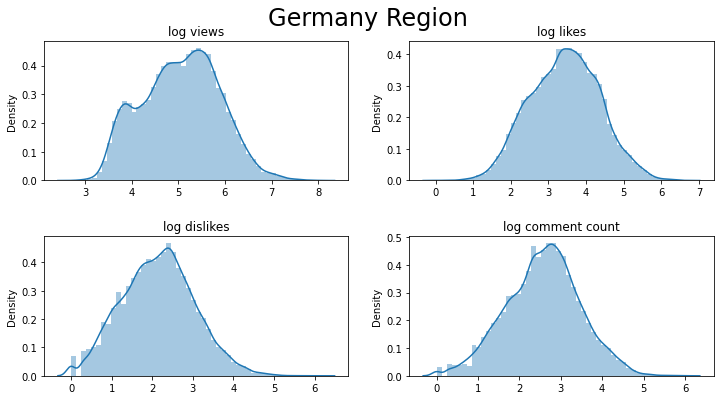

In [ ]:
getViewDataDistribution(df_DE, 'Germany Region')

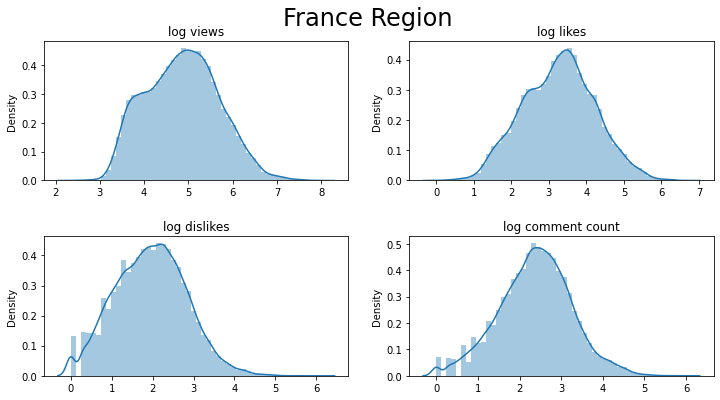

In [ ]:
getViewDataDistribution(df_FR, 'France Region')

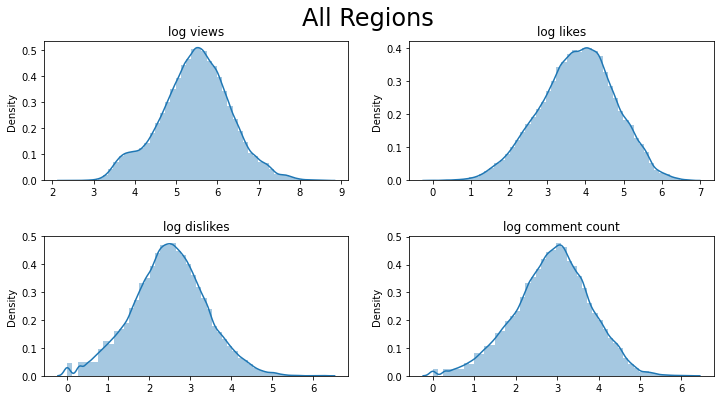

In [ ]:
getViewDataDistribution(df_ALL, 'All Regions')

# Categories Distribution

In [ ]:
def getCategoryDistribution(df, title):
    df = df.withColumn('log_views', sf.log10(df.views))
    category_plot_data = df.select(['category_title', 'log_views']).toPandas()

    fig = plt.figure(figsize = (14,9))
    fig.suptitle(title, fontsize=24)

    plt.subplot(211)
    g = sns.countplot(x='category_title', data=category_plot_data, palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Counting the Video Category ", fontsize=15)
    g.set_xlabel("", fontsize=12)
    g.set_ylabel("Count", fontsize=12)

    plt.subplot(212)
    g1 = sns.boxplot(x='category_title', y='log_views', data=category_plot_data, palette="Set1")
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title("Views Distribuition by Category Titles", fontsize=20)
    g1.set_xlabel("", fontsize=15)
    g1.set_ylabel("Views(log)", fontsize=15)

    plt.subplots_adjust(hspace = 0.9, top = 0.9)

    plt.show()

    del df
    gc.collect()

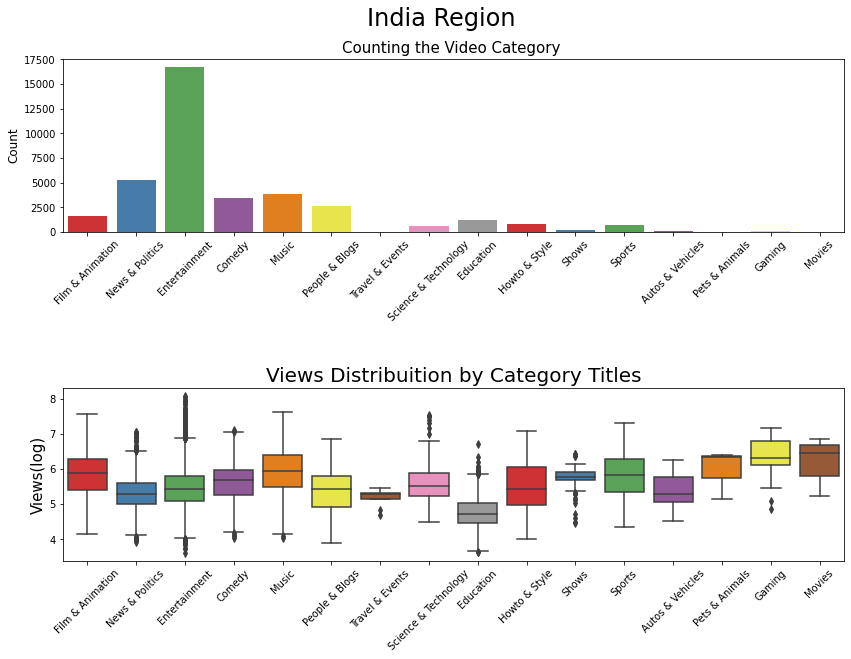

In [ ]:
getCategoryDistribution(df_IN, 'India Region')

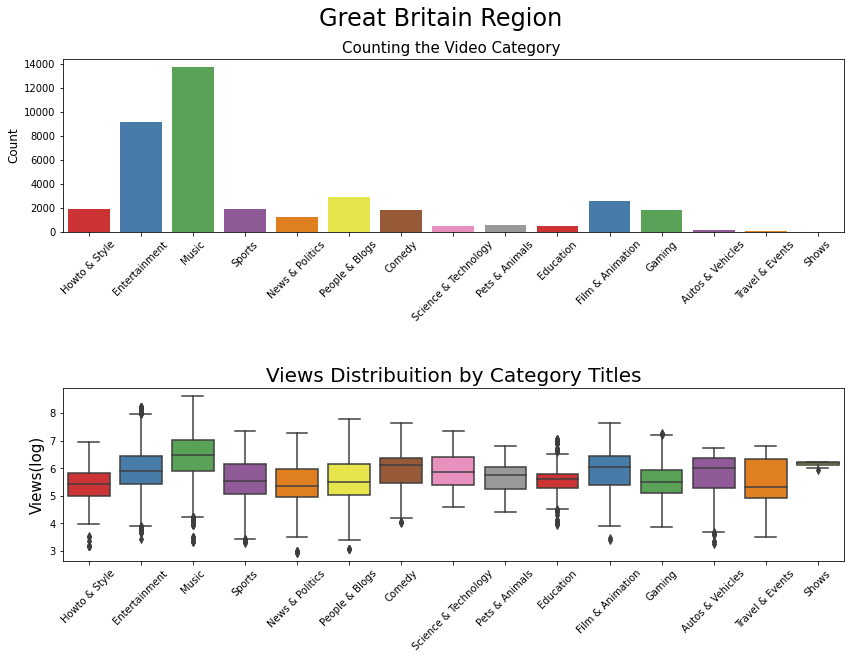

In [ ]:
getCategoryDistribution(df_GB, 'Great Britain Region')

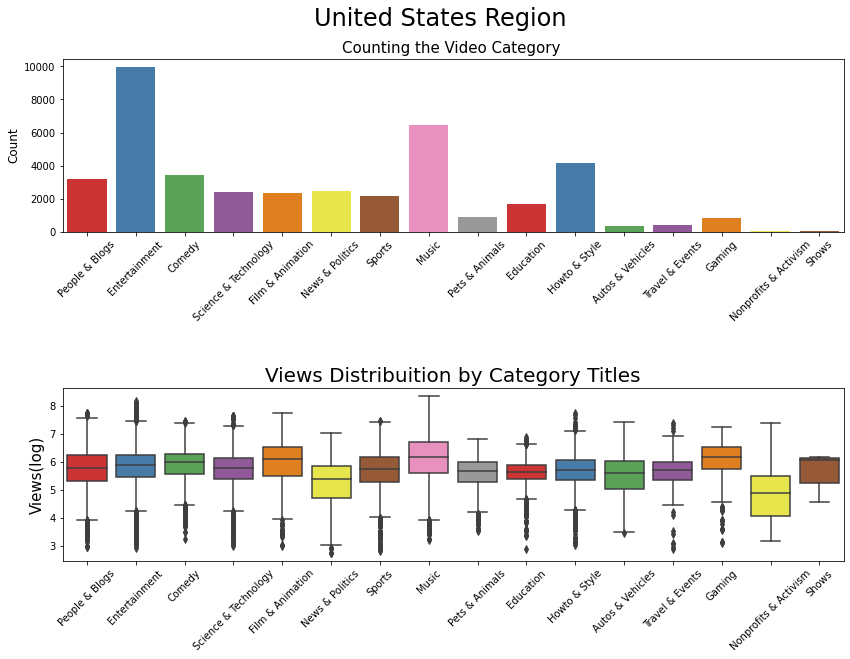

In [ ]:
getCategoryDistribution(df_US, 'United States Region')

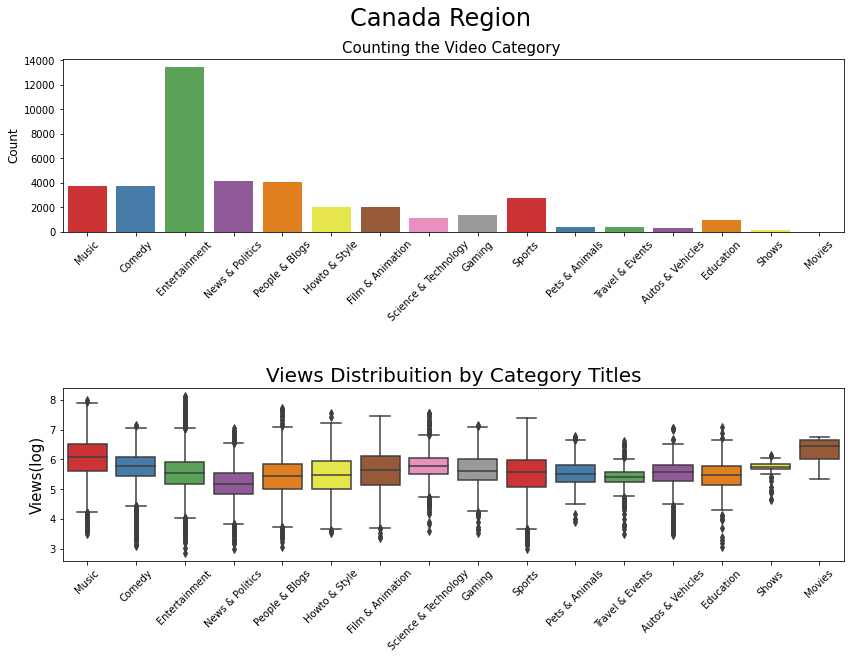

In [ ]:
getCategoryDistribution(df_CA, 'Canada Region')

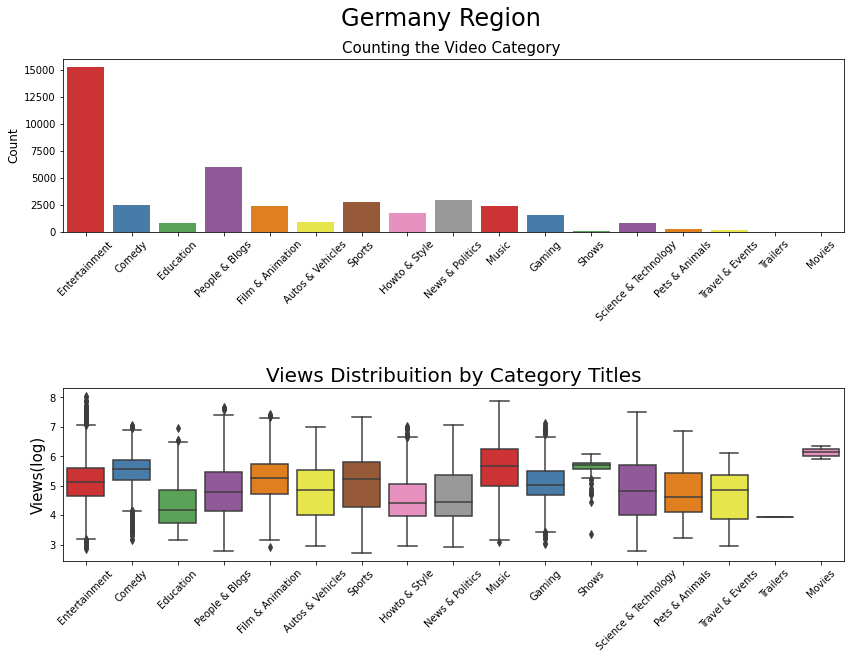

In [ ]:
getCategoryDistribution(df_DE, 'Germany Region')

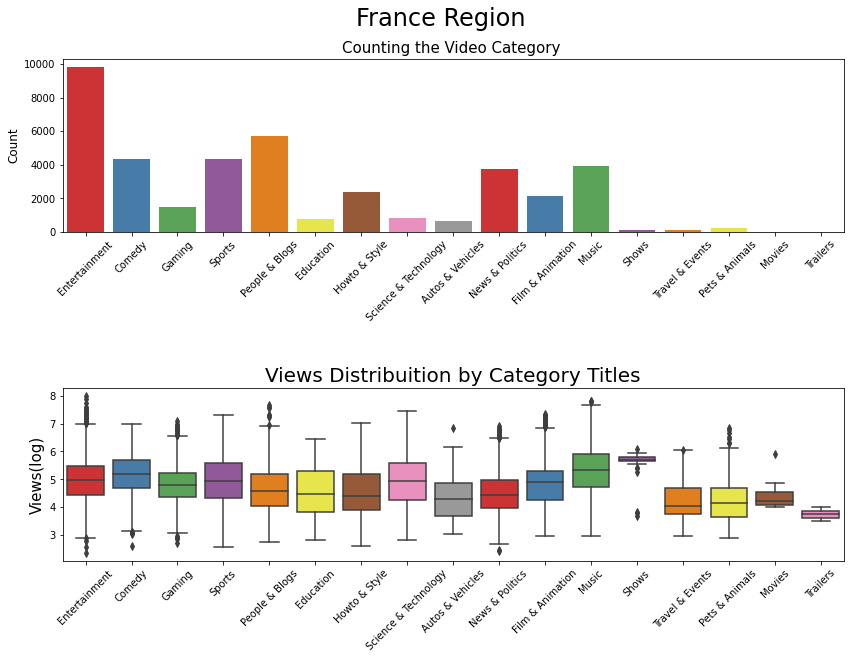

In [ ]:
getCategoryDistribution(df_FR, 'France Region')

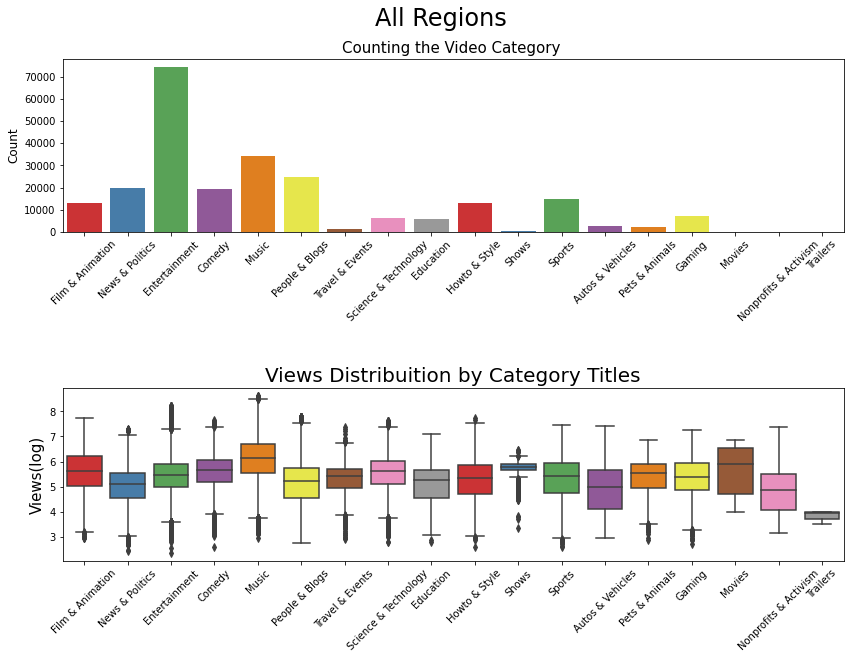

In [ ]:
getCategoryDistribution(df_ALL, 'All Regions')

# Correlation

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def getCorrelation(df):
    # convert to vector column first
    meaningful_cols = [
                      'category_id', 'views', 'likes', 'dislikes', 'comment_count'
                      ]
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=meaningful_cols, outputCol=vector_col, handleInvalid="skip")
    df_vector = assembler.transform(df).select(vector_col)

    # get correlation matrix
    corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

    plt.figure(figsize = (10,8))
    sns.heatmap(corr_matrix, annot=True, xticklabels=meaningful_cols, yticklabels=meaningful_cols)
    plt.show()

    del df_vector, corr_matrix
    gc.collect()

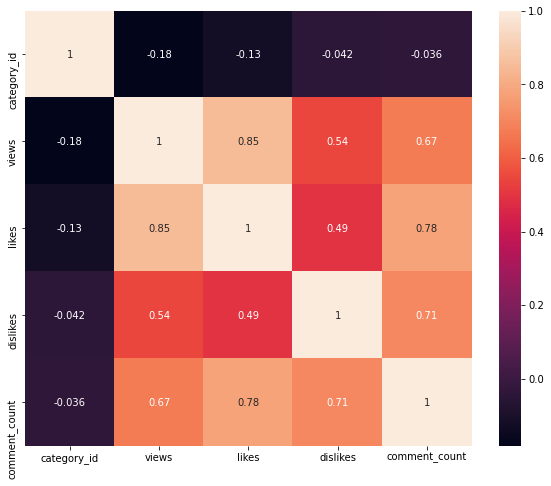

In [ ]:
getCorrelation(df_IN)

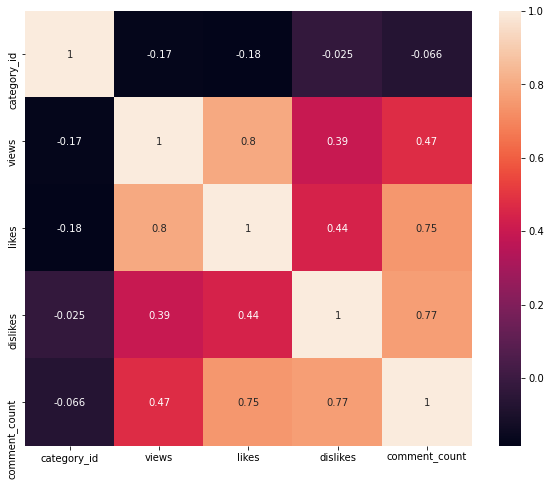

In [ ]:
getCorrelation(df_GB)

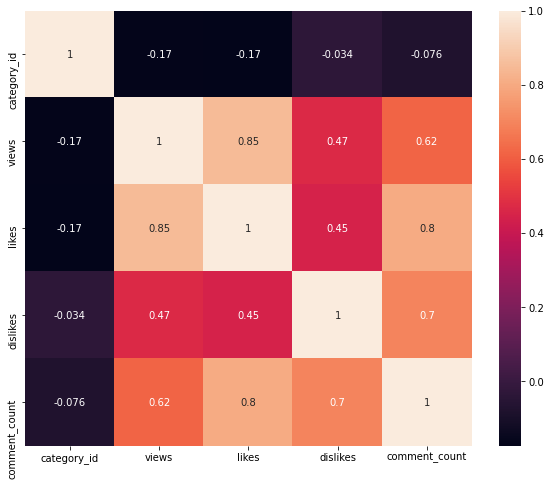

In [ ]:
getCorrelation(df_US)

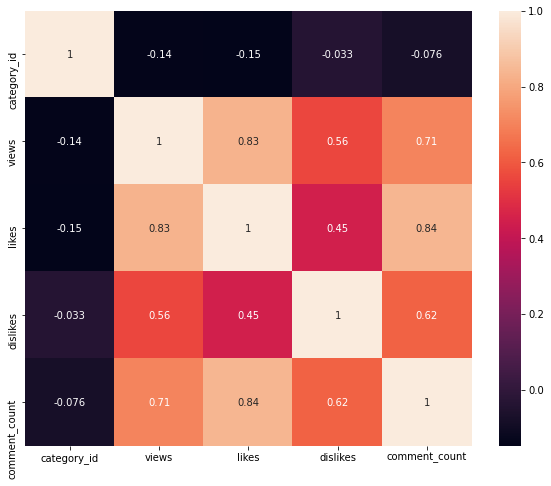

In [ ]:
getCorrelation(df_CA)

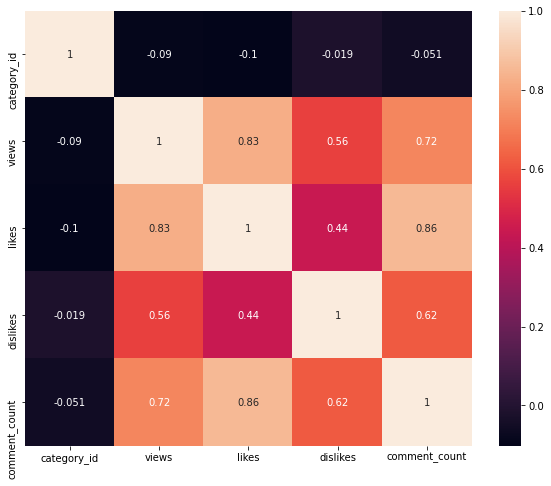

In [ ]:
getCorrelation(df_DE)

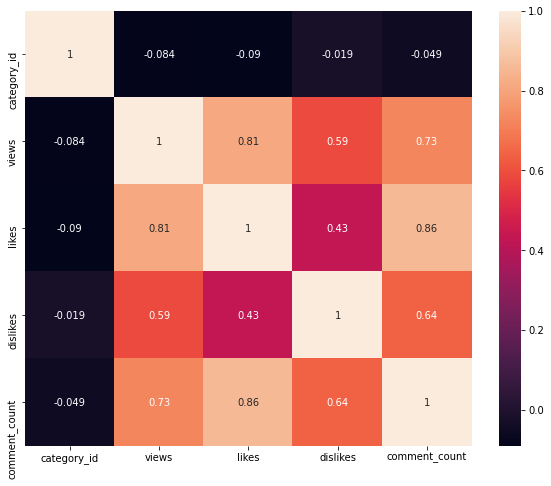

In [ ]:
getCorrelation(df_FR)

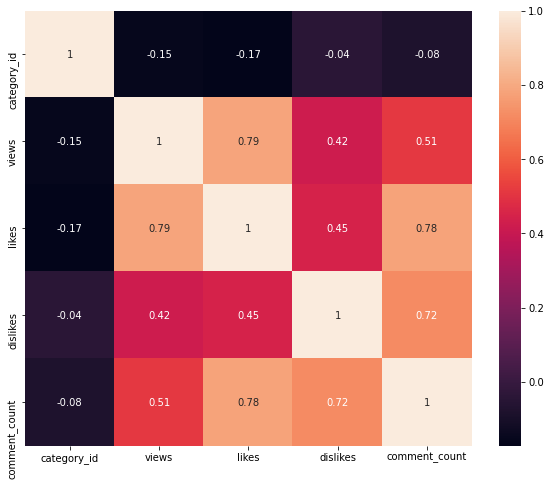

In [ ]:
getCorrelation(df_ALL)

# Bigrams

## Title Bigram

In [ ]:
from pyspark.ml.feature import NGram, RegexTokenizer

def getNGram(df, col, n, region):
    temp_df = df.withColumn(col, sf.regexp_replace(df[col], "[_:|\-\(\)\[\]]", ""))
    ngram_df = RegexTokenizer(inputCol=col, outputCol='words', pattern="\\s+").transform(temp_df)
    ngram_df = NGram(n=n, inputCol="words", outputCol="bigrams").transform(ngram_df)
    plot_data = ngram_df.select(sf.explode("bigrams").alias("bigram"))\
                        .groupBy("bigram").count().sort(sf.desc("count")).limit(20).toPandas()
                        
    plt.figure(figsize = (14,9))

    g = sns.catplot(data=plot_data, x='bigram', y='count', aspect=2, kind="bar", palette="Set1")
    g.set_xticklabels(rotation=45)
    axes = g.axes.flatten()
    axes[0].set_title("Counting the Top "+ col +" Bigram for "+region, fontsize=15)
    axes[0].set_ylabel("Count", fontsize=12)

    plt.show()

    del ngram_df
    gc.collect()

<Figure size 1008x648 with 0 Axes>

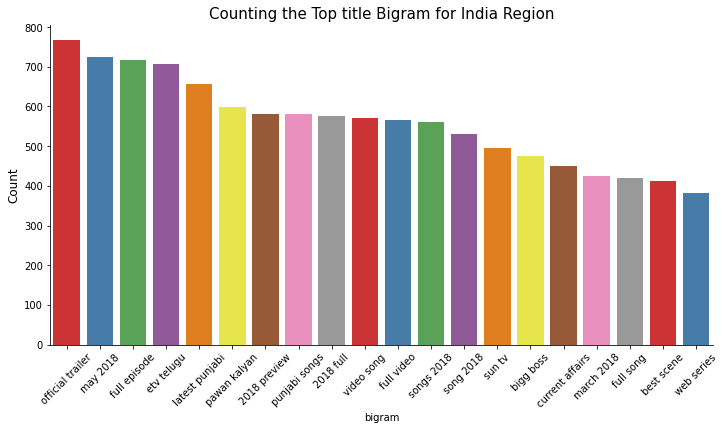

In [ ]:
getNGram(df_IN, 'title', 2, 'India Region')

<Figure size 1008x648 with 0 Axes>

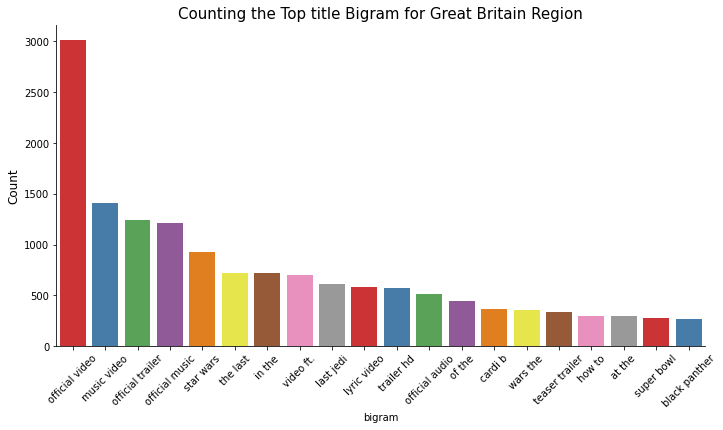

In [ ]:
getNGram(df_GB, 'title', 2, 'Great Britain Region')

<Figure size 1008x648 with 0 Axes>

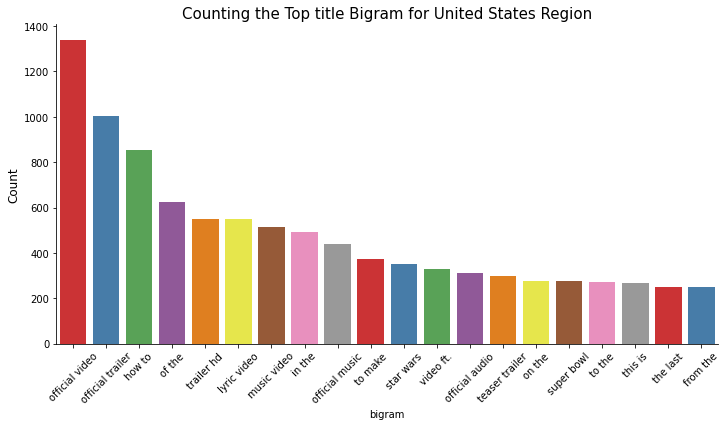

In [ ]:
getNGram(df_US, 'title', 2, 'United States Region')

<Figure size 1008x648 with 0 Axes>

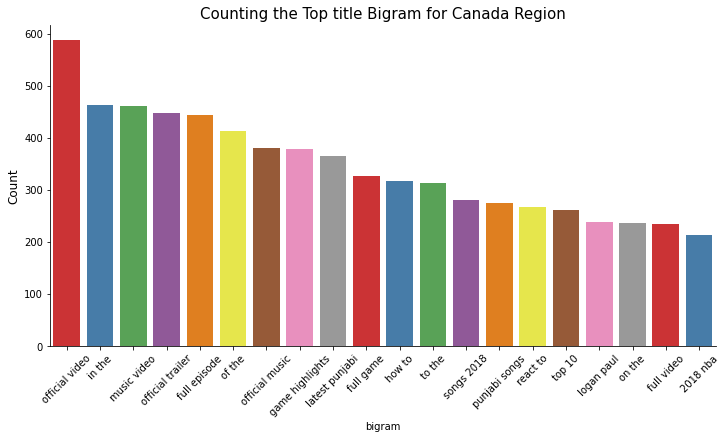

In [ ]:
getNGram(df_CA, 'title', 2, 'Canada Region')

<Figure size 1008x648 with 0 Axes>

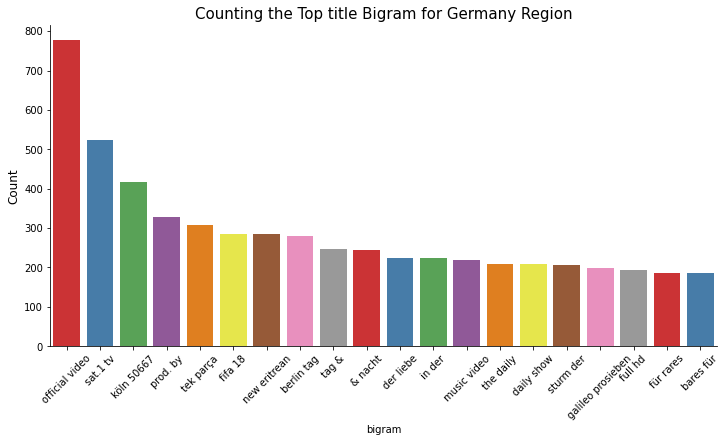

In [ ]:
getNGram(df_DE, 'title', 2, 'Germany Region')

<Figure size 1008x648 with 0 Axes>

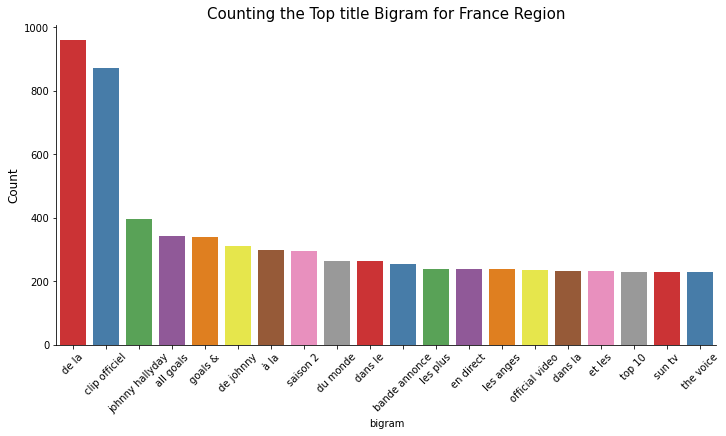

In [ ]:
getNGram(df_FR, 'title', 2, 'France Region')

<Figure size 1008x648 with 0 Axes>

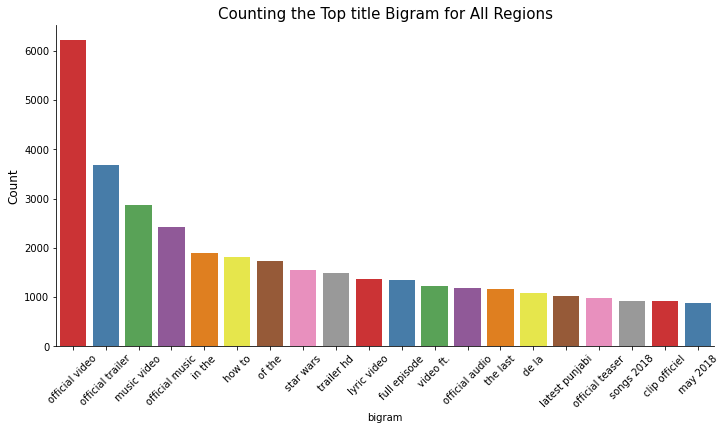

In [ ]:
getNGram(df_ALL, 'title', 2, 'All Regions')

## Description Bigram

<Figure size 1008x648 with 0 Axes>

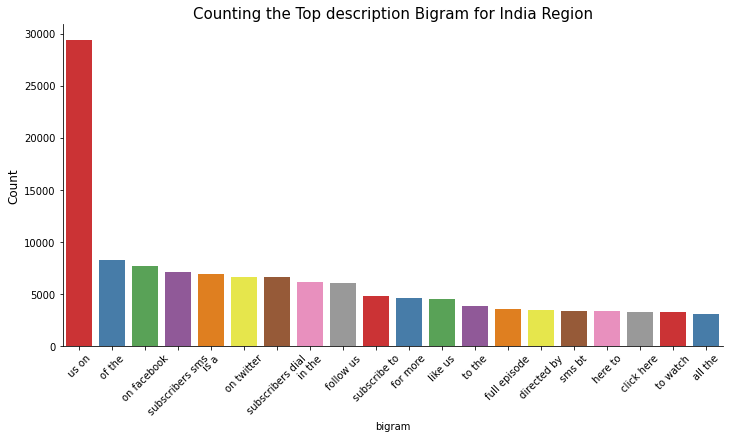

In [ ]:
getNGram(df_IN.fillna('No description', subset=['description']), 'description', 2, 'India Region')

<Figure size 1008x648 with 0 Axes>

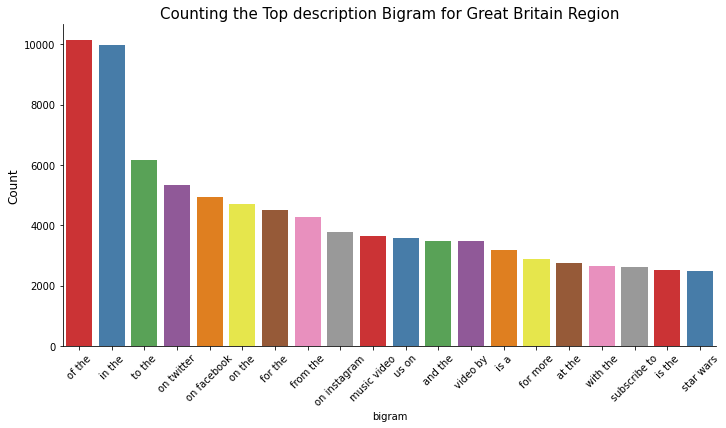

In [ ]:
getNGram(df_GB.fillna('No description', subset=['description']), 'description', 2, 'Great Britain Region')

<Figure size 1008x648 with 0 Axes>

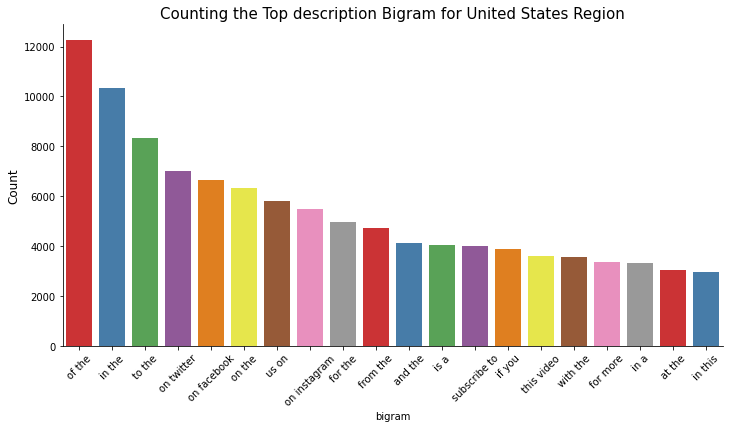

In [ ]:
getNGram(df_US.fillna('No description', subset=['description']), 'description', 2, 'United States Region')

<Figure size 1008x648 with 0 Axes>

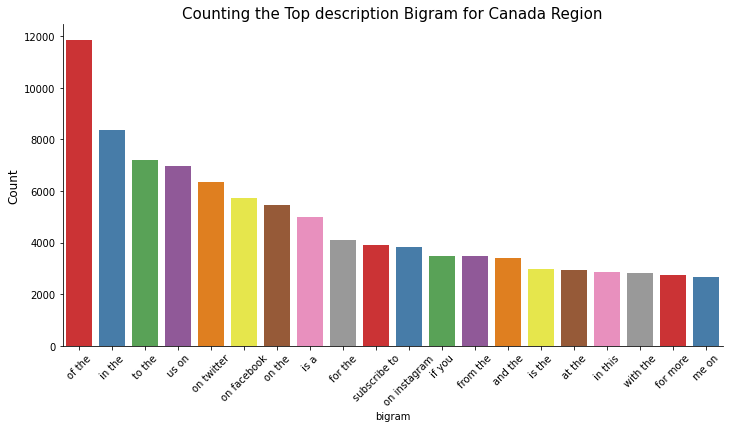

In [ ]:
getNGram(df_CA.fillna('No description', subset=['description']), 'description', 2, 'Canada Region')

<Figure size 1008x648 with 0 Axes>

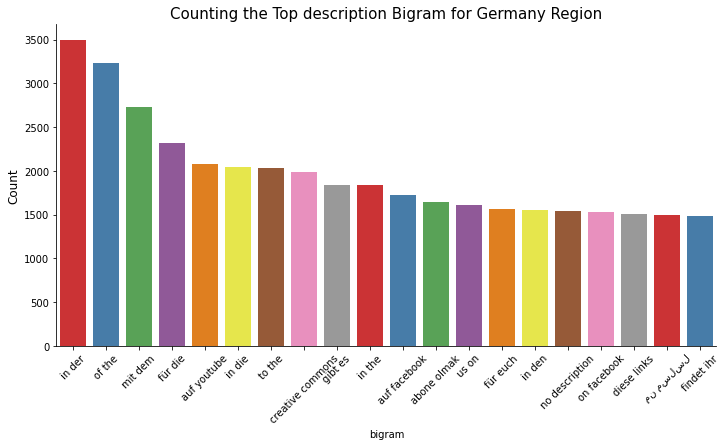

In [ ]:
getNGram(df_DE.fillna('No description', subset=['description']), 'description', 2, 'Germany Region')

<Figure size 1008x648 with 0 Axes>

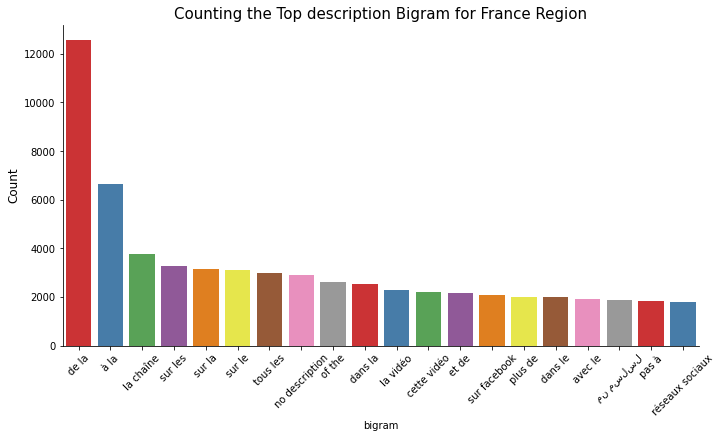

In [ ]:
getNGram(df_FR.fillna('No description', subset=['description']), 'description', 2, 'France Region')

<Figure size 1008x648 with 0 Axes>

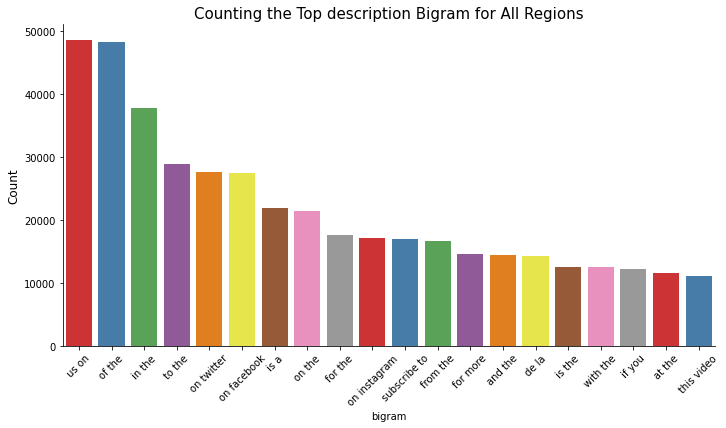

In [ ]:
getNGram(df_ALL.fillna('No description', subset=['description']), 'description', 2, 'All Regions')

# Language locale distribution

In [ ]:
def getLanguageDistribution(df, title):
    df = df.withColumn('log_views', sf.log10(df.views))
    target = df.select(['lang','log_views']).groupBy("lang").count().sort(sf.desc("count")).limit(20)
    plot_data = df.join(target, 'lang', 'inner').toPandas()

    fig = plt.figure(figsize = (14,9))
    fig.suptitle(title, fontsize=24)

    plt.subplot(211)
    g = sns.countplot(x='lang', data=plot_data, palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Conuting the Top 20 Languages ", fontsize=15)
    g.set_xlabel("", fontsize=12)
    g.set_ylabel("Count", fontsize=12)

    plt.subplot(212)
    g2 = sns.boxplot(x='lang', y='log_views', data=plot_data, palette="Set1")
    g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
    g2.set_title("Views Distribuition by Language", fontsize=20)
    g2.set_xlabel("", fontsize=15)
    g2.set_ylabel("Views(log)", fontsize=15)

    # plt.subplots_adjust(hspace = 0.9, top = 0.9)
    plt.show()

    del df, plot_data
    gc.collect()

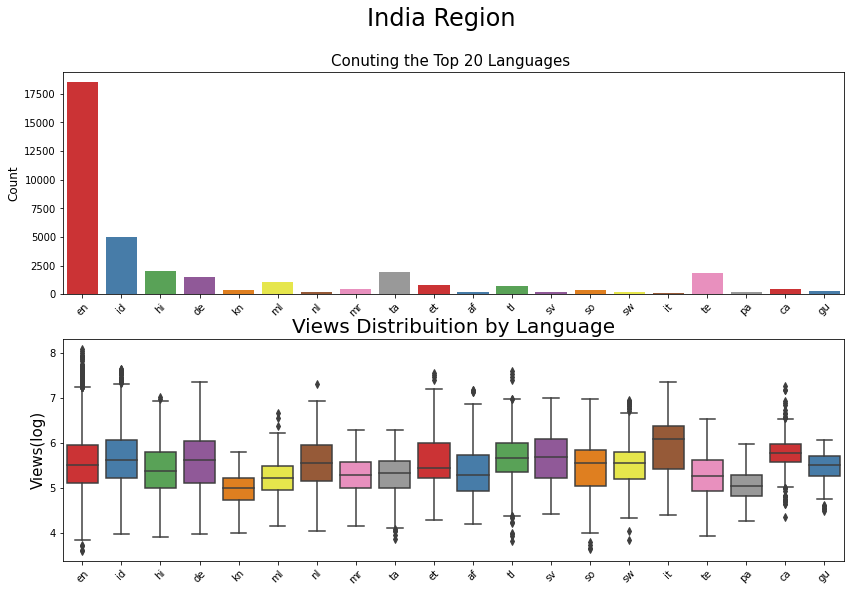

In [ ]:
getLanguageDistribution(df_IN, 'India Region')

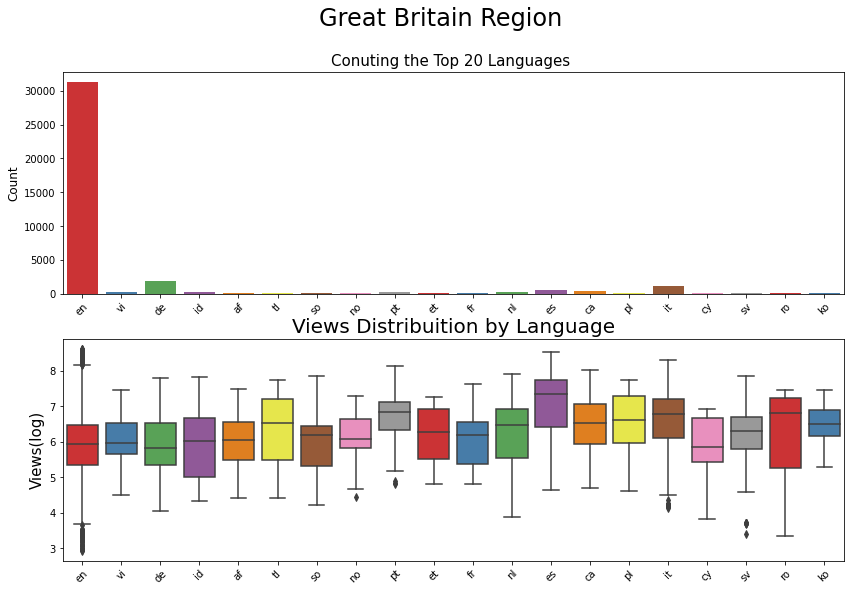

In [ ]:
getLanguageDistribution(df_GB, 'Great Britain Region')

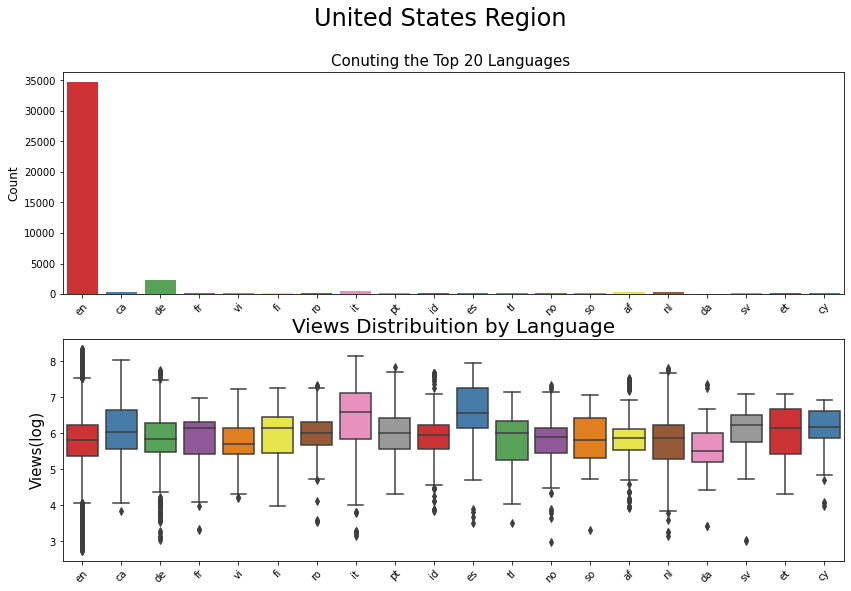

In [ ]:
getLanguageDistribution(df_US, 'United States Region')

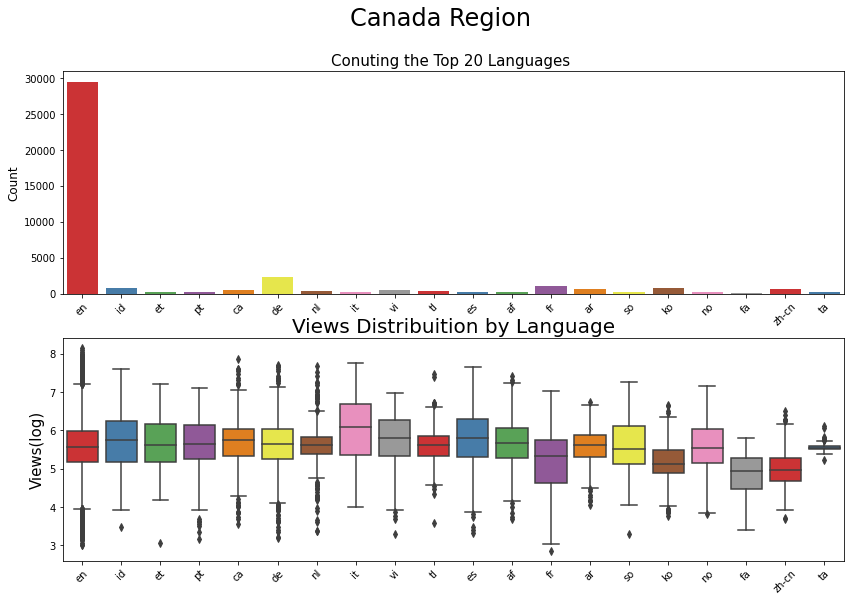

In [ ]:
getLanguageDistribution(df_CA, 'Canada Region')

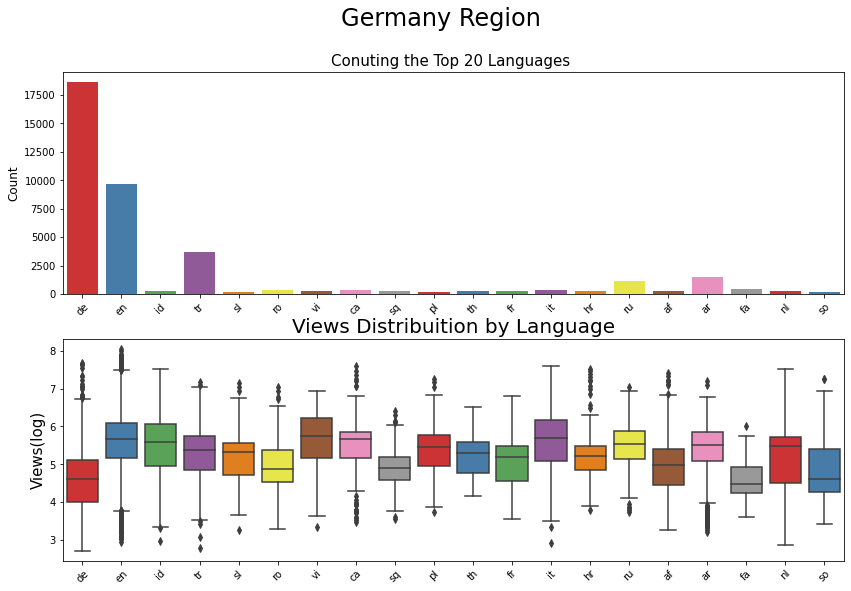

In [ ]:
getLanguageDistribution(df_DE, 'Germany Region')

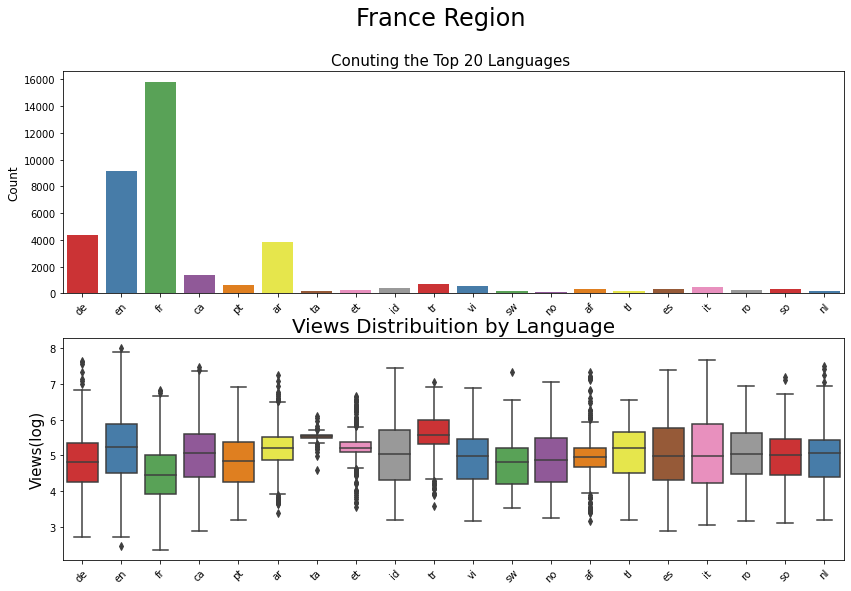

In [ ]:
getLanguageDistribution(df_FR, 'France Region')

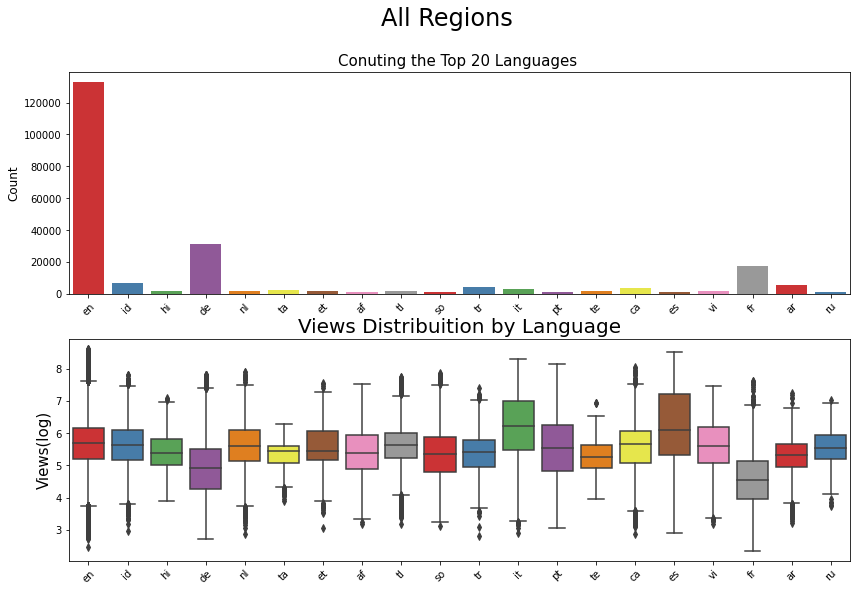

In [ ]:
getLanguageDistribution(df_ALL, 'All Regions')